# Automatic Learning of Key Phrases and Topics in Document Collections

## Part 4: Topic Model Summarization

### Overview

This notebook is Part 4 of 5 in a series providing a step-by-step description of how to process and analyze the contents of a large collection of text documents in an unsupervised manner. Using Python packages and custom code examples, we have implemented the basic framework that combines key phrase learning and latent topic modeling as described in the paper entitled ["Modeling Multiword Phrases with Constrained Phrases Tree for Improved Topic Modeling of Conversational Speech"](http://people.csail.mit.edu/hazen/publications/Hazen-SLT-2012.pdf) which was originally presented in the 2012 IEEE Workshop on Spoken Language Technology.

Although the paper examines the use of the technology for analyzing human-to-human conversations, the techniques are quite general and can be applied to a wide range natural language data including news stories, legal documents, research publications, social media forum discussion, customer feedback forms, product reviews, and many more.

Part 4 of the series shows how to summarize the contents of the document based on a trained LDA topic model. The summarization is applied to an LDA topic model learned in Part 3.  


### Import Relevant Python Packages

Most significantly, Part 3 relies on the use of the [Gensim Python library](http://radimrehurek.com/gensim/)  for generating a sparse bag-of-words representation of each document and then training a [Latent Dirichlet Allocation (LDA)](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) model on the data. LDA produces a collection of latent topics learned in a completely unsupervised fashion from the text data. Each document can then be represented with a distribution of the learned topics.

In [1]:
import numpy
import pandas 
import re
import math
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
from gensim import corpora
from gensim import models
from operator import itemgetter
from collections import namedtuple
import time
import gc
import sys
import multiprocessing
import os

### Load the Trained LDA Model Learned in Part 3 

> **NOTE** The data file is saved under the folder defined by environment variable `AZUREML_NATIVE_SHARE_DIRECTORY` in notebook 1. If you have changed it to `../Data`, please also do the change here.

In [2]:
# Load pretrained LDA topic model
ldaFile = os.path.join(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY'], "CongressionalDocsLDA.pickle")
lda = gensim.models.ldamodel.LdaModel.load(ldaFile)


In [3]:
# Get the mapping from token ID to token string
id2token = lda.id2word
print(id2token[1])

necessary


### Load the Mapping of Lower-Cased Vocabulary Items to Their Most Common Surface Form

In [4]:
# Load surface form mappings here
fp = open(os.path.join(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY'], "Vocab2SurfaceFormMapping.tsv"))

vocabToSurfaceFormHash = {}

# Each line in the file has two tab separated fields;
# the first is the vocabulary item used during modeling
# and the second is its most common surface form in the 
# original data
for stringIn in fp.readlines():
    fields = stringIn.strip().split("\t")
    if len(fields) != 2:
        print ("Warning: Bad line in surface form mapping file: %s" % stringIn)
    elif fields[0] == "" or fields[1] == "":
        print ("Warning: Bad line in surface form mapping file: %s" % stringIn)
    else:
        vocabToSurfaceFormHash[fields[0]] = fields[1]
fp.close()


In [5]:
def CreateTermIDToSurfaceFormMapping(id2token, token2surfaceform):
    termIDToSurfaceFormMap = []
    for i in range(0, len(id2token)):
        if id2token[i] in token2surfaceform:
            termIDToSurfaceFormMap.append(token2surfaceform[id2token[i]])
    return termIDToSurfaceFormMap;

termIDToSurfaceFormMap = CreateTermIDToSurfaceFormMapping(id2token, vocabToSurfaceFormHash);

In [6]:
# print out the modeled token form and the best matching surface for the token with the index value of 20
i = 20
print('Term index:', i)
print('Modeled form:', id2token[i])
print('Surface form:', termIDToSurfaceFormMap[i])

Term index: 20
Modeled form: inauguration
Surface form: inauguration


### Use the Build-in <i> print_topics </i> Method to Summarize a Random Sample of 10 Topics

In [7]:
numTopics = lda.num_topics
print ("Number of topics:", numTopics)
lda.print_topics(10)

Number of topics: 200


[(166,
  '0.053*"history" + 0.047*"abortion" + 0.045*"honors" + 0.023*"declaration" + 0.021*"amends_federal_law" + 0.021*"content" + 0.020*"rescission" + 0.018*"weight" + 0.018*"save" + 0.017*"contains"'),
 (14,
  '0.040*"lea" + 0.024*"change" + 0.020*"civil_rights" + 0.019*"immigrant" + 0.016*"student\'s" + 0.015*"authorize_the_secretary" + 0.014*"spouses" + 0.014*"references" + 0.014*"withhold" + 0.014*"school_year"'),
 (50,
  '0.131*"tribal" + 0.032*"tribes" + 0.023*"band" + 0.022*"restricted" + 0.021*"replace" + 0.017*"hold" + 0.014*"united_states" + 0.014*"pass" + 0.012*"all" + 0.012*"jurisdiction"'),
 (86,
  '0.079*"travel" + 0.069*"initiative" + 0.035*"update" + 0.032*"fraud" + 0.027*"abuse" + 0.023*"code" + 0.022*"pesticide" + 0.016*"society" + 0.015*"ethics" + 0.010*"travel_expenses"'),
 (113,
  '0.052*"women" + 0.031*"preservation" + 0.029*"boundaries" + 0.026*"cultural" + 0.025*"boundary" + 0.022*"preserve" + 0.016*"women\'s" + 0.015*"historical" + 0.015*"equity_act" + 0.014

### Use Word Cloud to Visualize a Topic

In [8]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def _terms_to_counts(terms, multiplier=1000):
    return ' '.join([' '.join(int(multiplier * x[1]) * [x[0]]) for x in terms])


def visualizeTopic(lda, topicID=0, topn=500, multiplier=1000):
    terms = []
    tmp = lda.show_topic(topicID, topn)
    for term in tmp:
        terms.append(term)
    
    # If the version of wordcloud is higher than 1.3, then you will need to set 'collocations' to False.
    # Otherwise there will be word duplicates in the figure. 
    try:
        wordcloud = WordCloud(max_words=10000, collocations=False).generate(_terms_to_counts(terms, multiplier))
    except:
        wordcloud = WordCloud(max_words=10000).generate(_terms_to_counts(terms, multiplier))
    fig = plt.figure(figsize=(12, 16))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Topic %d" % topicID)
    plt.show()
    

In [9]:
%matplotlib inline

Visualize topic \#38 using Word Cloud. This topic seems to be related to national security.

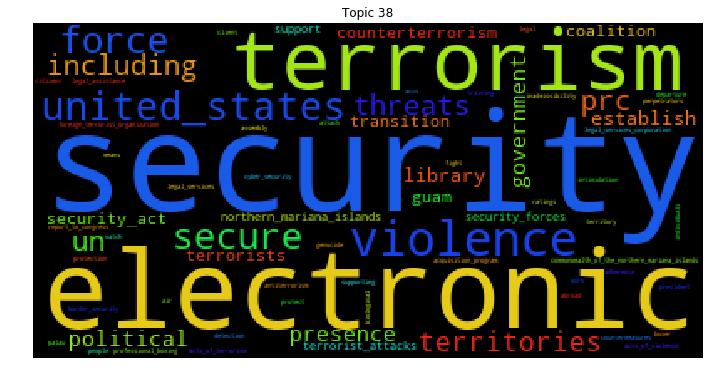

In [10]:
visualizeTopic(lda, topicID=38, topn=1000)

Visualize topic \#168 using Word Cloud. This topic is mainly related to health care.

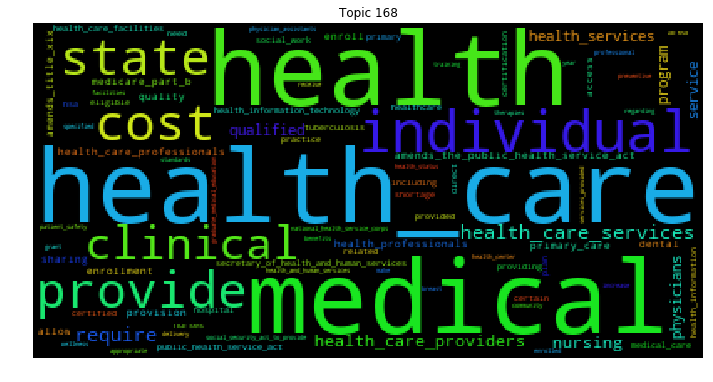

In [11]:
visualizeTopic(lda, topicID=168, topn=1000)

### Load the Document Probability Score P(topic|doc) Computed by the LDA Model from File

In this section, each document from the corpus is passed into the LDA model which then infers the topic distribution for each document. The topic distributions are collected into a single numpy array.

In [12]:
docTopicProbsFile = os.path.join(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY'], "CongressionalDocTopicProbs.npy")

# docTopicProbs[docID,TopicID] --> P(topic|doc)
docTopicProbs = numpy.load(docTopicProbsFile)

# The docTopicProbs shape should be (# of docs, # of topics)
docTopicProbs.shape

(297462, 200)

### Compute the Global Topic Likelihood Scores P(topic)

In [13]:
# Computing the global topic likelihoods by aggregating topic probabilities over all documents
# topicProbs[topicID] --> P(topic)
def ComputeTopicProbs(docTopicProbs):
    topicProbs = docTopicProbs.sum(axis=0) 
    topicProbs = topicProbs/sum(topicProbs)
    return topicProbs

topicProbs = ComputeTopicProbs(docTopicProbs)

#### Convert the Topic Language Model Information P(term|topic) from the LDA Model into a NumPy Representation

In [14]:
def ExtractTopicLMMatrix(lda):
    # Initialize the matrix
    docTopicProbs = numpy.zeros((lda.num_topics,lda.num_terms))
    for topicID in range(0,lda.num_topics):
        termProbsList = lda.get_topic_terms(topicID,lda.num_terms)
        for termProb in termProbsList:
            docTopicProbs[topicID,termProb[0]]=termProb[1]
    return docTopicProbs
    
# topicTermProbs[topicID,termID] --> P(term|topic)
topicTermProbs = ExtractTopicLMMatrix(lda)

In [15]:
# Set this to true if you want to save the Topic LMs for a newly trained LDA model to file
if True:
    numpy.save(os.path.join(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY'], "CongressionalDocTopicLM.npy"), topicTermProbs)

#### Compute P(topic,term), P(term), and P(topic|term)

In [16]:
# Compute the joint likelihoods of topics and terms
# jointTopicTermProbs[topicID,termID] --> P(topic,term) = P(term|topic)*P(topic)
jointTopicTermProbs = numpy.diag(topicProbs).dot(topicTermProbs) 

# termProbs[termID] --> P(term)
termProbs = jointTopicTermProbs.sum(axis=0)

# topicProbsPermTerm[topicID,termID] --> P(topic|term)
topicProbsPerTerm = jointTopicTermProbs / termProbs

In [17]:
# Print most frequent words in LDA vocab
mostFrequentTermIDs = (-termProbs).argsort()
for i in range(0,25):
    print ("%d: %s --> %f" % (i+1, id2token[mostFrequentTermIDs[i]], termProbs[mostFrequentTermIDs[i]]))

1: amends --> 0.005384
2: requires --> 0.004441
3: national --> 0.003563
4: provides --> 0.003309
5: state --> 0.003208
6: certain --> 0.003189
7: program --> 0.003045
8: including --> 0.002890
9: united_states --> 0.002783
10: provide --> 0.002542
11: harmonized_tariff_schedule_of_the_united_states --> 0.002519
12: individual --> 0.002294
13: all --> 0.002225
14: specified --> 0.002102
15: prohibits --> 0.002008
16: states --> 0.001916
17: december_31 --> 0.001869
18: authorizes --> 0.001784
19: programs --> 0.001750
20: service --> 0.001748
21: federal --> 0.001656
22: respect --> 0.001651
23: credit --> 0.001631
24: services --> 0.001586
25: requirements --> 0.001486


#### Compute WPMI

To determine which vocabulary terms are most representative of a topic, systems typically just choose a set of terms that are most likely for the topic, i.e., terms that maximize the language model expression <i>P(term|topic)</i> for the given topic. This approach is adequate for many data sets. However, for some data sets there may be common words in the corpus that are frequent terms within multiple topics, and hence not a distinguishing term for any of these topics. In this case, selecting words which have the largest weighted pointwise mutual information (WPMI) with a given topic is more appropriate. 

The expression for WPMI between a word and token is given as:


$WPMI(term,topic) = P(term,topic)\log\frac{P(term,topic)}{P(term)P(topic)} = P(term,topic)\log\frac{P(topic|term)}{P(topic)}$


In [18]:
topicTermWPMI =(jointTopicTermProbs.transpose()*numpy.log(topicProbsPerTerm.transpose()/topicProbs)).transpose()
topicTermWPMI.shape

(200, 68145)

#### Compute Topic to Document Purity measure for Each Topic

One measure of the importance or quality of a topic is its topic to document purity measure. This purity measure assumes latent topics that dominate the documents in which they appear are more semantically important than latent topics that are weakly spread across many documents. This concept was introduced in the paper ["Latent Topic Modeling for Audio Corpus Summarization](http://people.csail.mit.edu/hazen/publications/Hazen-Interspeech11.pdf). The purity measure is expressed by the following equation:

$Purity(topic) = \exp\left (
                 \frac{\sum_{\forall doc}P(topic|doc)\log P(topic|doc)}{\sum_{\forall doc}P(topic|doc)}
                \right )$

In [19]:
topicPurity = numpy.exp(((docTopicProbs * numpy.log(docTopicProbs)).sum(axis=0))/(docTopicProbs).sum(axis=0))

#### Create Topic Summaries 

In the code snippet below we demonstrate how the WPMI measure lowers to score of some common tokens that do not provide value in a topic summary in comparison to the standard word likely measure P(token|topic). For topic 2 below notice how the generic words <i>person</i>, <i>United States</i>, and <i>Provides</i> have their position in the summaries lowered by the WPMI measure relative to the straight P(token|topic) measure, while the WMPI measure improves the ranking for the content bearing tokens <i>felony</i>, <i>sentencing</i> and <i>forfeiture</i>.  

In [20]:
topicID = 2
highestWPMITermIDs = (-topicTermWPMI[topicID]).argsort()
highestProbTermIDs = (-topicTermProbs[topicID]).argsort()
print ("                                        WPMI                                                 Prob")
for i in range(0,15):
    print ("%2d: %35s ---> %8.6f    %35s ---> %8.6f" % (i+1, 
                                                        termIDToSurfaceFormMap[highestWPMITermIDs[i]], 
                                                        topicTermWPMI[topicID,highestWPMITermIDs[i]],
                                                        termIDToSurfaceFormMap[highestProbTermIDs[i]], 
                                                        topicTermProbs[topicID,highestProbTermIDs[i]]))                

                                        WPMI                                                 Prob
 1:                          laboratory ---> 0.000645                             laboratory ---> 0.032246
 2:                               units ---> 0.000557                                  units ---> 0.031042
 3:                                acid ---> 0.000387                                 source ---> 0.020129
 4:                        laboratories ---> 0.000374                                   acid ---> 0.019149
 5:              surface transportation ---> 0.000370                           laboratories ---> 0.018911
 6:                              source ---> 0.000336                 surface transportation ---> 0.018326
 7:                            standard ---> 0.000254                               standard ---> 0.017568
 8:                            emission ---> 0.000240                              standards ---> 0.012892
 9:                   owner or operator ---> 0

In [21]:
def CreateTopicSummaries(topicTermScores, id2token, tokenid2surfaceform, maxStringLen):
    reIgnore = re.compile('^[a-z]\.$')
    reAcronym = re.compile('^[A-Z]+$')
    topicSummaries = []
    for topicID in range(0,len(topicTermScores)):
        rankedTermIDs = (-topicTermScores[topicID]).argsort()
        maxNumTerms = len(rankedTermIDs)
        termIndex = 0
        stop = 0
        outputTokens = []
        prevAcronyms = []
        topicSummary = ""
        while not stop:
            # If we've run out of tokens then stop...
            if (termIndex>=maxNumTerms):
                stop=1
            # ...otherwise consider adding next token to summary
            else:
                nextToken = id2token[rankedTermIDs[termIndex]]
                nextTokenOut = tokenid2surfaceform[rankedTermIDs[termIndex]]
                keepToken = 1
                
                # Prepare to test current word as an acronym or a string that reduces to an acronym
                nextTokenIsAcronym = 0
                nextTokenAbbrev = ""
                if reAcronym.match(nextTokenOut) != None:
                    nextTokenIsAcronym = 1
                else:
                    subTokens = nextToken.split('_')
                    if (len(subTokens)>1):
                        for subToken in subTokens:
                            nextTokenAbbrev += subToken[0]                        

                # See if we should ignore this token because it matches the regex for tokens to ignore
                if ( reIgnore.match(nextToken) != None ):
                    keepToken = 0;

                # Otherwise see if we should ignore this token because
                # it is a close match to a previously selected token
                elif len(outputTokens) > 0:          
                    for prevToken in outputTokens:
                        # Ignore token if it is a substring of a previous token
                        if nextToken in prevToken:
                            keepToken = 0
                        # Ignore token if it is a superstring of a previous token
                        elif prevToken in nextToken:
                            keepToken = 0
                        # Ignore token if it is an acronym of a previous token
                        elif nextTokenIsAcronym:
                            subTokens = prevToken.split('_')
                            if (len(subTokens)>1):
                                prevTokenAbbrev = ""
                                for subToken in subTokens:
                                    prevTokenAbbrev += subToken[0]
                                if prevTokenAbbrev == nextToken:
                                    keepToken = 0                                  
                    for prevAcronym in prevAcronyms:
                        # Ignore token if it is the long form of an earlier acronym
                        if nextTokenAbbrev == prevAcronym:
                                keepToken = 0

                # Add tokens to the summary for this topic                
                if keepToken:
                    # Always add at least one token to the summary
                    if len(topicSummary) == 0 or ( len(topicSummary) + len(nextTokenOut) + 1 < maxStringLen):
                        if len(topicSummary) == 0:
                            topicSummary = nextTokenOut
                        else: 
                            topicSummary += ", " + nextTokenOut
                        outputTokens.append(nextToken)
                        if nextTokenIsAcronym:
                            prevAcronyms.append(nextToken)
                    # If we didn't add the previous word and we're within 10 characters of 
                    # the max string length then we'll just stop here
                    elif maxStringLen - len(topicSummary) < 10 :
                        stop = 1
                    # Otherwise if the current token is too long, but we still have more than
                    # 10 characters of space left we'll just skip this one and add the next token
                    # one if it's short enough
                termIndex += 1         
        topicSummaries.append(topicSummary)
    return topicSummaries   
    
topicSummaries = CreateTopicSummaries(topicTermWPMI, id2token, termIDToSurfaceFormMap, 85)

In [22]:
# Rank the topics by their prominence score in the corpus
# The topic score combines the total weight of each a topic in the corpus 
# with a topic document purity score for topic 
# Topics with topicScore > 1 are generally very strong topics

topicScore = (numTopics * topicProbs) * (2 * topicPurity)
topicRanking = (-topicScore).argsort()

### Print Out Topical Summary of the Entire Corpus 

In [23]:
print ("Rank  ID  Score  Prob  Purity  Summary")
for i in range(0, numTopics):
    topicID = topicRanking[i]
    print (" %3d %3d %6.3f (%5.3f, %4.3f) %s" 
           % (i+1, topicID, topicScore[topicID], 100*topicProbs[topicID], topicPurity[topicID], topicSummaries[topicID]))

Rank  ID  Score  Prob  Purity  Summary
   1 165  5.076 (2.510, 0.506) Amends, Harmonized Tariff Schedule of the United States, December 31, duty, suspend
   2 174  1.827 (1.101, 0.415) Immigration and Nationality Act, admission, United States for permanent residence
   3 114  1.456 (1.611, 0.226) property, tax, qualified, income, interest, Amends the Internal Revenue Code, Defines
   4  59  1.224 (1.497, 0.204) National, day, USDA, Week, Memorial, Designates, honor, March, importance, events
   5 139  0.957 (1.269, 0.189) benefits, individual, Social Security, month, Survivors and Disability Insurance
   6 140  0.734 (0.904, 0.203) Medicare, payment, Social Security Act, Medicaid, title XVIII, spectrum, OASDI
   7 120  0.675 (0.969, 0.174) DOE, account, certain, distributions, qualified, gross income, allow, exclusion
   8 147  0.674 (1.029, 0.164) Congress, fiscal year, budget, legislation, GAO, report, Requires, estimate, enacted
   9  33  0.576 (1.020, 0.141) credit, Amends the Inte

### Save LDA Topic Summaries

In [24]:
# If you want to save out the summaries to file makes this True
if True:
    fp = open(os.path.join(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY'], "CongressionalDocTopicSummaries.tsv"), "w")
    i = 0
    fp.write("TopicID\tTopicSummary\n")
    for line in topicSummaries:
        fp.write("%d\t%s\n" % (i, line))
        i += 1
    fp.close()

The topic model summization step is finished. The next will be topic modeling analysis which will be in the fifth notebook of the series: [`5_Topic_Model_Analysis.ipynb`](5_Topic_Model_Analysis.ipynb).